In [1]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
from numpy import s_
import pyproj
from pyproj import CRS
import xarray as xr

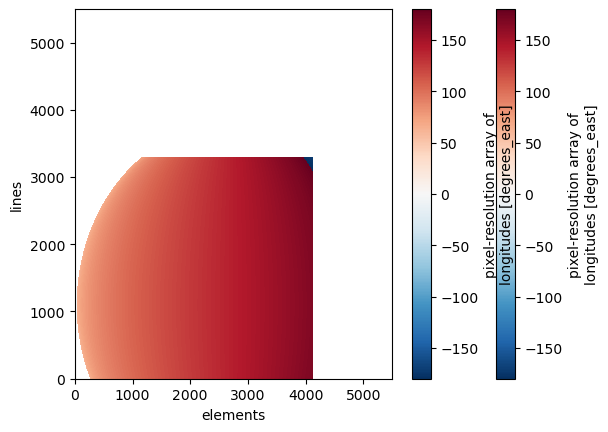

In [2]:
file = '/g/data/gy85/Himawari8_AusGeo1-0-3/L1/summer_2015-2016/201511/geocatL1.HIMAWARI-8.2015305.000000.FLDK.R20.nc'
file2 = '/g/data/gy85/Himawari8_AusGeo1-0-3/L1/summer_2015-2016/201511/geocatL1.HIMAWARI-8.2015305.010000.FLDK.R20.nc'
data = xr.open_dataset(file)
data2 = xr.open_dataset(file2)
data.chunk(chunks={'elements': 5000, 'lines': 5000})
data2.chunk(chunks={'elements': 5000, 'lines': 5000})
data.pixel_longitude.plot()
data2.pixel_longitude.plot()

In [11]:
data

<xarray.Dataset>
Dimensions:                                           (lines: 5500,
                                                       elements: 5500)
Dimensions without coordinates: lines, elements
Data variables: (12/25)
    himawari_8_ahi_channel_10_brightness_temperature  (lines, elements) float32 ...
    himawari_8_ahi_channel_11_brightness_temperature  (lines, elements) float32 ...
    himawari_8_ahi_channel_12_brightness_temperature  (lines, elements) float32 ...
    himawari_8_ahi_channel_13_brightness_temperature  (lines, elements) float32 ...
    himawari_8_ahi_channel_14_brightness_temperature  (lines, elements) float32 ...
    himawari_8_ahi_channel_15_brightness_temperature  (lines, elements) float32 ...
    ...                                                ...
    pixel_latitude                                    (lines, elements) float32 ...
    pixel_longitude                                   (lines, elements) float32 ...
    pixel_relative_azimuth_angle                      (lines, elements) float32 ...
    pixel_satellite_zenith_angle                      (lines, elements) float32 ...
    pixel_solar_zenith_angle                          (lines, elements) float32 ...
    pixel_surface_type                                (lines, elements) float32 ...
Attributes: (12/66)
    Ancillary_Data_Directory:              ./data/
    Ancillary_Package_Version:             NA
    Channel_Number_Convention:             instrument-native
    Earth-Sun_Distance:                    0.9924923181533813
    Element_Resolution:                    2.0
    Element_Stride:                        1
    ...                                    ...
    time_coverage_end:                     2020-03-31
    geospatial_lat_min:                    -51.42
    geospatial_lat_max:                    23.09
    geospatial_lon_min:                    70.16
    geospatial_lon_max:                    188.8
    id:                                    http://dx.doi.org/10.25914/6009622...

In [3]:
ds = data.rename({
    "pixel_latitude": "lat",
    "pixel_longitude": "lon"
})

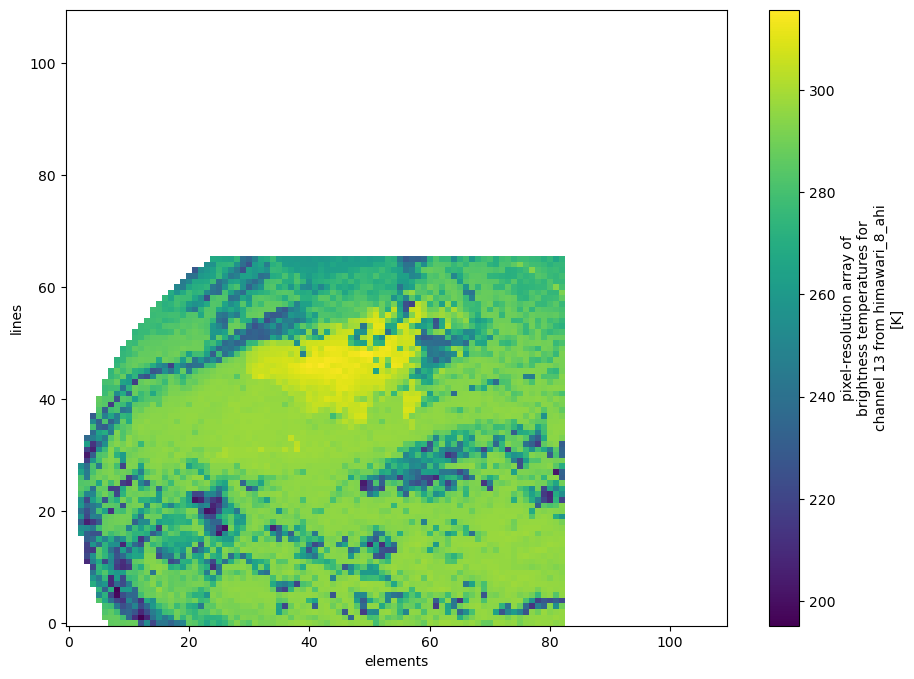

In [18]:
# ds.himawari_8_ahi_channel_13_brightness_temperature.isel(lines=s_[0::50], elements=s_[0::50]).plot(size=8);


In [4]:
# create target output grid
lon = np.arange(140, 155, 0.18)
lon = xr.DataArray(lon, dims=('lon',), coords={'lon': lon}, attrs={'name': 'Longitude', 'units': 'degree_east'})

lat = np.arange(-22, -12, 0.18)
lat = xr.DataArray(lat, dims=('lat',), coords={'lat': lat}, attrs={'name': 'Latitude', 'units': 'degree_north'})

out_grid=xr.Dataset({'lat': lat, 'lon': lon})
lat = np.flipud(lat)
lonmesh, latmesh = np.meshgrid(lon, lat)

In [5]:
# define grid systems
source_crs = CRS.from_proj4("+proj=latlong +lat_ts=23.777885 +lat_0=-53.524277 +lon_0=0 +x_0=0 +y_0=0 +a=6378.137 +b=6356.7523 +units=km +type=crs")
target_crs = pyproj.CRS(init="epsg:4326") # Global lat-lon coordinate system 

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [6]:
# transform source grid to target output grid
latlon_to_geo = pyproj.Transformer.from_crs(target_crs,source_crs)

In [7]:
# transform each lat/long coordinate in new grid to himawari pixel lat lon
x_him8, y_him8 = latlon_to_geo.transform(lonmesh, latmesh)

In [8]:
x_h8 = xr.DataArray(x_him8, dims=('lon','lat'))
y_h8 = xr.DataArray(y_him8, dims=('lon','lat'))

In [9]:
%%time
data_h8 = ds.drop_vars(['himawari_8_ahi_channel_10_brightness_temperature','himawari_8_ahi_channel_11_brightness_temperature','himawari_8_ahi_channel_12_brightness_temperature',
                         'himawari_8_ahi_channel_14_brightness_temperature','himawari_8_ahi_channel_15_brightness_temperature','himawari_8_ahi_channel_16_brightness_temperature',
                         'himawari_8_ahi_channel_1_reflectance','himawari_8_ahi_channel_2_reflectance','himawari_8_ahi_channel_3_reflectance','himawari_8_ahi_channel_4_reflectance',
                         'himawari_8_ahi_channel_5_reflectance','himawari_8_ahi_channel_6_reflectance','himawari_8_ahi_channel_7_brightness_temperature','himawari_8_ahi_channel_7_emissivity',
                         'himawari_8_ahi_channel_7_reflectance','himawari_8_ahi_channel_8_brightness_temperature','himawari_8_ahi_channel_9_brightness_temperature','pixel_ecosystem_type',
                         'pixel_relative_azimuth_angle','pixel_satellite_zenith_angle','pixel_solar_zenith_angle','pixel_surface_type']
                        ).interp({'elements':x_h8, 'lines':y_h8}, method='nearest').load()
data_h8

CPU times: user 296 ms, sys: 48.9 ms, total: 345 ms
Wall time: 506 ms


<xarray.Dataset>
Dimensions:                                           (lon: 56, lat: 84)
Dimensions without coordinates: lon, lat
Data variables:
    himawari_8_ahi_channel_13_brightness_temperature  (lon, lat) float32 nan ...
    lat                                               (lon, lat) float32 nan ...
    lon                                               (lon, lat) float32 nan ...
    elements                                          (lon, lat) float64 140....
    lines                                             (lon, lat) float64 -12....
Attributes: (12/66)
    Ancillary_Data_Directory:              ./data/
    Ancillary_Package_Version:             NA
    Channel_Number_Convention:             instrument-native
    Earth-Sun_Distance:                    0.9924923181533813
    Element_Resolution:                    2.0
    Element_Stride:                        1
    ...                                    ...
    time_coverage_end:                     2020-03-31
    geospatial_lat_min:                    -51.42
    geospatial_lat_max:                    23.09
    geospatial_lon_min:                    70.16
    geospatial_lon_max:                    188.8
    id:                                    http://dx.doi.org/10.25914/6009622...

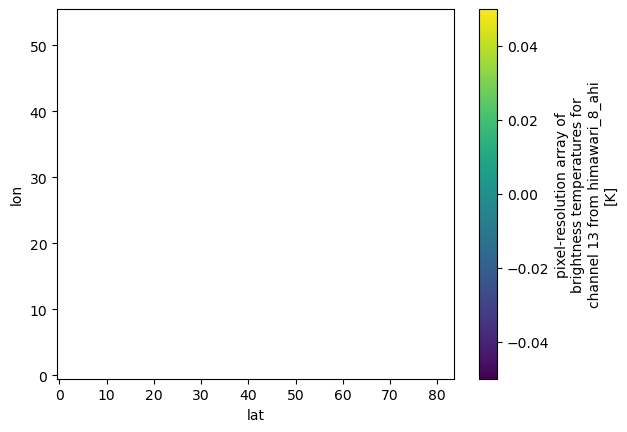

In [10]:
# data_ch13 = data_h8.assign_coords({'lon': (('lon'), data_h8.lon.data), 'lat': (('lat'), data_h8.lat.data)}).drop_vars(['elements','lines']).reset_coords()
data_h8.himawari_8_ahi_channel_13_brightness_temperature.plot()

In [ ]:
data_h8.himawari_8_ahi_channel_13_brightness_temperature.plot()